# Performance Evaluation

In this notebook is present the code to evalute the performances obtained on : 

*  The benchmark ("*Twitter Testing Dataset I*") using the predictions produced by all the models.
*  The Test set of the T4SA-family dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/MyDrive/Thesis/"
DATASET_DIR = BASE_DIR + "dataset/t4sa/"
BENCHMARK_DIR = BASE_DIR + "dataset/benchmark/Twitter1269/"
PREDICTION_DIR = BASE_DIR + "predictions/"

# Utility mappers to switch different labeling modality
mapper_label_to_int = {'NEG': 0, 'NEU':1, 'POS':2}
mapper_int_to_label = {0:'NEG', 1:'NEU', 2:'POS'}

binary_label_to_int = {'NEG': 0, 'POS':1}

# Statistics obtained on the Twitter Testing Dataset I

In [ ]:
def maximum_value_in_column(column):  
  '''Change the font weigth to bold of the element with the highest value in the colum of the dataframe given as input.'''  

  highlight = 'font-weight: bold;text-align: center;'   # style of highest value
  default = 'text-align: center;'                       # style of all the others
  maximum_in_column = column.max()

  # return one string per cell in this column
  return [highlight if v == maximum_in_column else default for v in column]


def print_all_statistics_benchmark(benchmark, models):
  '''Print the statistics of all the models passed as input on the benchmark.'''  
  
  # get a list with all the predictions generated by the model passed as input
  predictions_list = [pd.read_csv(models[model] + 'at_least_' + benchmark + '.csv') for model in models.keys()]

  # load the benchmark to get the gold labels
  test_annot = pd.read_csv(BENCHMARK_DIR + benchmark + "agree.csv")
  gold_labels = test_annot['label'].apply(int).tolist()

  fpr_s=[]
  tpr_s=[]
  th_s=[]
  roc_auc_s=[]
  f1_negatives=[]
  f1_positives=[]
  f1_macros = []
  accuracies=[]

  for predictions in predictions_list:

    # Remove the neutral class predictions, since is not present in the benchmark
    predictions.drop('NEU', inplace=True, axis=1)
    
    pred_labels = predictions.to_numpy()

    fp, tp, th = roc_curve(gold_labels, pred_labels[:,1])   # Compute Receiver operating characteristic (ROC) curve 
    roc_auc = roc_auc_score(gold_labels, pred_labels[:,1])  # Compute the area under the curve to get a global indicator of the statistic
    
    fpr_s.append(fp)
    tpr_s.append(tp)
    th_s.append(th)
    roc_auc_s.append(roc_auc)

    # it returns the column of the df that corresponds to the maximum
    pred_labels = predictions.idxmax(axis = 1).to_list()
  
    # map the column to the id of the class
    pred_labels = [binary_label_to_int[label] for label in pred_labels]

    f1_summary = f1_score(gold_labels, pred_labels, average=None)   # Compute the F1 on single classes
    f1_macro = f1_score(gold_labels, pred_labels, average="macro")  # Compute the F1-macro to get a global statistic on all the classes  
    curr_accuracy = accuracy_score(pred_labels, gold_labels)        # Compute the accuracy

    f1_negatives.append(f1_summary[0])
    f1_positives.append(f1_summary[1])
    f1_macros.append(f1_macro)
    accuracies.append(curr_accuracy)

  models_list = models.keys()

  print(f"Statistics obtained on the at_least_{benchmark} dataset:")
  raw_data = {'Model': models_list, 'Accuracy': accuracies, 'F1-macro': f1_macros, 'Roc-auc': roc_auc_s}
  F1_scores = pd.DataFrame(raw_data)
  display(F1_scores.style.hide_index().apply(maximum_value_in_column, subset=['Accuracy', 'F1-macro', 'Roc-auc'], axis=0))

  print(f"\n\nF1 on single classes obtained on the at_least_{benchmark} dataset:")
  raw_data = {'Model': models_list, 'Negative': f1_negatives, 'Positive': f1_positives}
  F1_scores = pd.DataFrame(raw_data)
  display(F1_scores.style.hide_index().apply(maximum_value_in_column, subset=['Negative', 'Positive'], axis=0))

  # plot the Roc Curve of the models in a single graph
  plt.subplots(1, figsize=(10,10))
  plt.title(f'\n\nReceiver Operating Characteristic - Benchmark at_least_{benchmark}')
  for model, fpr, tpr in zip(models_list, fpr_s, tpr_s):
    plt.plot(fpr, tpr, label = '%s'%model)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend()
  plt.show()

In [ ]:
models_predictions_mapper = {"vit_original":PREDICTION_DIR + 'benchmark/t4sa/vit_original/', 
          "vit_new": PREDICTION_DIR + 'benchmark/t4sa/vit_new/',
          "vit_new_filtered": PREDICTION_DIR + 'benchmark/t4sa/vit_new_filtered/',
          "t4sa2.0": PREDICTION_DIR + 'benchmark/t4sa2.0/',
          }

Statistics obtained on the at_least_5 dataset:


Model,Accuracy,F1-macro,Roc-auc
vit_original,0.811791,0.801589,0.892996
vit_new,0.821995,0.782203,0.881908
vit_new_filtered,0.846939,0.813165,0.884121
t4sa2.0,0.823129,0.803930,0.877791




F1 on single classes obtained on the at_least_5 dataset:


Model,Negative,Positive
vit_original,0.756598,0.846580
vit_new,0.689109,0.875298
vit_new_filtered,0.733728,0.892601
t4sa2.0,0.742574,0.865285


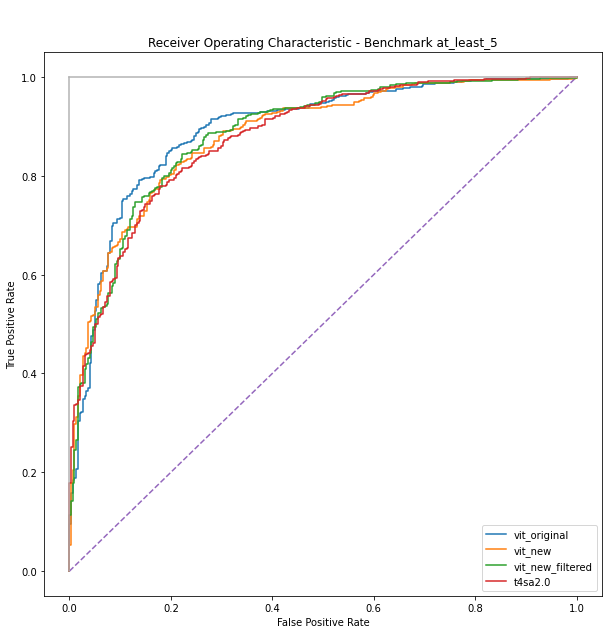

In [ ]:
print_all_statistics_benchmark("5", models_predictions_mapper)

Statistics obtained on the at_least_4 dataset:


Model,Accuracy,F1-macro,Roc-auc
vit_original,0.776882,0.771895,0.865012
vit_new,0.780466,0.746405,0.850481
vit_new_filtered,0.796595,0.765391,0.857697
t4sa2.0,0.786738,0.774097,0.849318




F1 on single classes obtained on the at_least_4 dataset:


Model,Negative,Positive
vit_original,0.738170,0.805621
vit_new,0.653465,0.839344
vit_new_filtered,0.679831,0.850952
t4sa2.0,0.720657,0.827536


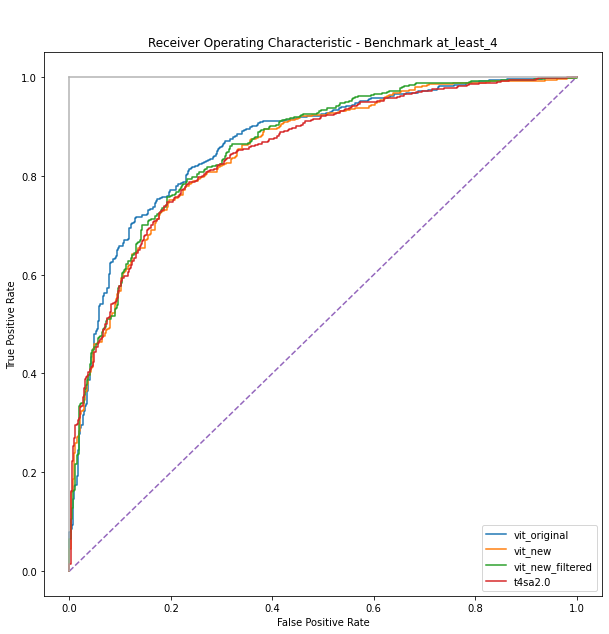

In [ ]:
print_all_statistics_benchmark("4", models_predictions_mapper)

Statistics obtained on the at_least_3 dataset:


Model,Accuracy,F1-macro,Roc-auc
vit_original,0.743105,0.739514,0.829546
vit_new,0.754925,0.720739,0.813242
vit_new_filtered,0.765957,0.734632,0.823427
t4sa2.0,0.753349,0.741835,0.811931




F1 on single classes obtained on the at_least_3 dataset:


Model,Negative,Positive
vit_original,0.708929,0.770099
vit_new,0.623030,0.818447
vit_new_filtered,0.643457,0.825806
t4sa2.0,0.687313,0.796357


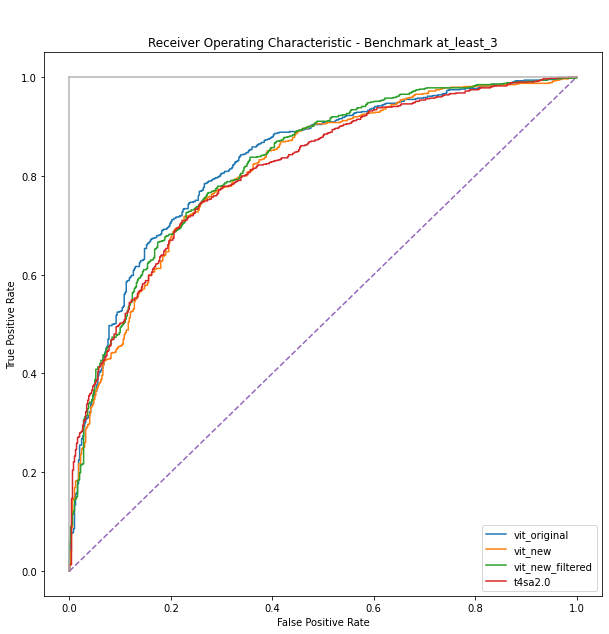

In [ ]:
print_all_statistics_benchmark("3", models_predictions_mapper)

# Statistics of model trained on T4SA 1.0 variants (ablation study) 

In [ ]:
def print_statistics_T4SA(predictions, annots):
  '''Print the statistics of all the models of the T4SA family.'''
  class_disribution_s = []
  f1_negatives=[]
  f1_neutrals=[]
  f1_positives=[]
  f1_macros = []
  accuracies=[]

  models_list = predictions.keys()

  for model in models_list:
    test_annot = annots[model]
    gold_labels = test_annot['label'].apply(int).tolist()   # get gold labels

    class_disribution, counts = np.unique(gold_labels, return_counts=True)  # get class distribution
    class_disribution_s.append(counts)

    preds = predictions[model]
    # it returns the column of the df that corresponds to the maximum
    pred_labels = preds.idxmax(axis = 1).to_list()   

    pred_labels = [mapper_label_to_int[label] for label in pred_labels]  # maps label to their integer code 

    #  plot the confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, xticks_rotation='vertical', ax=ax)
    plt.title(f'\n\nConfusion matrix relative to the {model} test set predictions\n\n\n')

    f1_summary = f1_score(gold_labels, pred_labels, average=None)   # Compute the F1 on single classes
    f1_macro = f1_score(gold_labels, pred_labels, average="macro")  # Compute the F1-macro to get a global statistic on all the classes  
    curr_accuracy = accuracy_score(pred_labels, gold_labels)        # Compute the accuracy

    f1_negatives.append(f1_summary[0])
    f1_neutrals.append(f1_summary[2])
    f1_positives.append(f1_summary[2])
    f1_macros.append(f1_macro)
    accuracies.append(curr_accuracy)  

  print(f"Statistics obtained on the test:")
  raw_data = {'Model': models_list, 'Accuracy': accuracies, 'F1-macro': f1_macros}
  F1_scores = pd.DataFrame(raw_data)
  display(F1_scores.style.hide_index().apply(maximum_value_in_column, subset=['Accuracy', 'F1-macro'], axis=0))

  class_disribution_s = np.asarray(class_disribution_s)
  print(f"\n\nClasses distribution in  the test set:")
  raw_data = {'Model': models_list, 'Negative': class_disribution_s[:, 0], 'Neutral': class_disribution_s[:, 1], 'Positive': class_disribution_s[:, 2]}
  F1_scores = pd.DataFrame(raw_data)
  display(F1_scores.style.hide_index())

  print(f"\n\nF1 on single classes obtained on the test set:")
  raw_data = {'Model': models_list, 'Negative': f1_negatives, 'Neutral': f1_neutrals, 'Positive': f1_positives}
  F1_scores = pd.DataFrame(raw_data)
  display(F1_scores.style.hide_index().apply(maximum_value_in_column, subset=['Negative', 'Neutral', 'Positive'], axis=0))



In [ ]:
models_annot_T4SA_mapper = {"vit_original": pd.read_csv(DATASET_DIR + "original_text_predictions/b-t4sa_test.txt", delimiter=" ", header=None, names=["path", "label"], dtype=str), 
                            "vit_new": pd.read_csv(DATASET_DIR + "new_text_predictions/bt4sa/b-t4sa_test.tsv", delimiter="\t", names=["path", "label"], header=None, dtype=str, skiprows=1),
                            "vit_new_filtered": pd.read_csv(DATASET_DIR + "new_text_predictions/bt4sa_filtered_70/b-t4sa_test_filtered_70.tsv", delimiter="\t", names=["path", "label"], header=None, dtype=str, skiprows=1),
                            }

models_predictions_T4SA_mapper = {"vit_original": pd.read_csv(PREDICTION_DIR + 'b-t4sa/vit_original.csv'), 
                                  "vit_new": pd.read_csv(PREDICTION_DIR + 'b-t4sa/vit_new.csv'),
                                  "vit_new_filtered": pd.read_csv(PREDICTION_DIR + 'b-t4sa/vit_new_filtered.csv'),
                                  }

Statistics obtained on the test:


Model,Accuracy,F1-macro
vit_original,0.521569,0.521294
vit_new,0.537373,0.501391
vit_new_filtered,0.581558,0.531111




Classes distribution in  the test set:


Model,Negative,Neutral,Positive
vit_original,17000,17000,17000
vit_new,10283,19790,20927
vit_new_filtered,7003,14078,18351




F1 on single classes obtained on the test set:


Model,Negative,Neutral,Positive
vit_original,0.540553,0.513502,0.513502
vit_new,0.358837,0.583840,0.583840
vit_new_filtered,0.370227,0.651471,0.651471


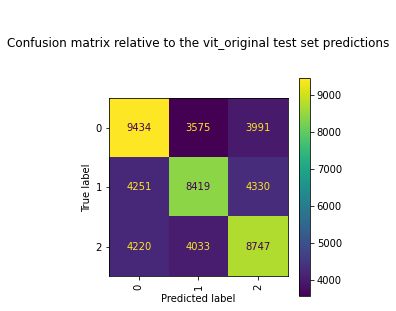

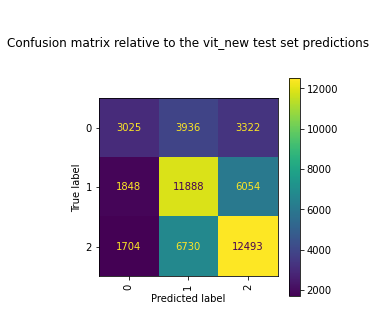

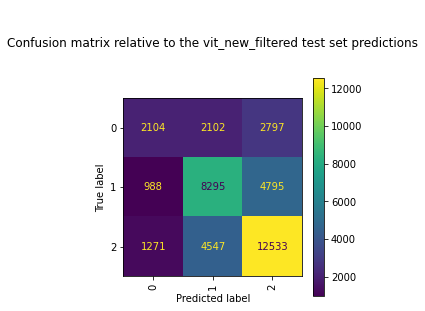

In [ ]:
print_statistics_T4SA(models_predictions_T4SA_mapper, models_annot_T4SA_mapper)